In [14]:
#load images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import matplotlib.pyplot as plt 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from PIL import Image
import os
%matplotlib inline

In [19]:
batch_size = 16
train_data_dir = "raw_data/training-data-exp/"
#test_data_dir = "raw_data/test-data-binary/"

train_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "int",  
  seed=123,
  image_size=(225, 225),
  batch_size=batch_size,
  validation_split=0.2,
  subset='both'
) 

train_data = train_ds[0]
val_data = train_ds[1]

Found 636 files belonging to 3 classes.
Using 509 files for training.
Using 127 files for validation.


In [20]:
class_names = train_data.class_names
class_names

['clean', 'damage', 'dirt']

### Model

In [8]:
# We'll use a model with the same convolutional layers, but we'll add Augmentation layers before that

model_multi = Sequential()

model_multi.add(layers.Rescaling(1./255, input_shape = (225, 225, 3)))

# Data Augmentation Layers

model_multi.add(layers.RandomFlip("horizontal"))
model_multi.add(layers.RandomZoom(0.1))
model_multi.add(layers.RandomTranslation(0.2, 0.2))
model_multi.add(layers.RandomRotation(0.1))


# Convolutional Layers

model_multi.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_multi.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_multi.add(layers.Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_multi.add(layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_multi.add(layers.Flatten())

model_multi.add(layers.Dense(64, activation="relu"))

model_multi.add(layers.Dropout(0.5))

model_multi.add(layers.Dense(3, activation="softmax"))

In [9]:
model_multi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 225, 225, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 225, 225, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 225, 225, 3)       0         
                                                                 
 random_translation (RandomT  (None, 225, 225, 3)      0         
 ranslation)                                                     
                                                                 
 random_rotation (RandomRota  (None, 225, 225, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      8

In [15]:
adam = optimizers.Adam(learning_rate = 0.001)

model_multi.compile(loss= SparseCategoricalCrossentropy(),
              optimizer= adam,
              metrics=['accuracy'])

In [16]:
MODEL = "model_multi"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [17]:
%%time
#'clean', 'damage', 'dirt'
history_multi = model_multi.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper],
        class_weight = {
            0: 3.0,
            1: 6.0,
            2: 2.0
        }
        )


Epoch 1/30
32/32 [==============================] - 26s 649ms/step - loss: 3.4911 - accuracy: 0.3084 - val_loss: 1.0894 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - 29s 852ms/step - loss: 3.4009 - accuracy: 0.4126 - val_loss: 1.1470 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - 25s 756ms/step - loss: 3.3451 - accuracy: 0.2809 - val_loss: 1.0041 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 4/30
32/32 [==============================] - 24s 718ms/step - loss: 3.3251 - accuracy: 0.4401 - val_loss: 0.9923 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 5/30
32/32 [==============================] - 40s 1s/step - loss: 3.2230 - accuracy: 0.4361 - val_loss: 1.0187 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 6/30
32/32 [==============================] - 25s 736ms/step - loss: 3.2207 - accuracy: 0.4872 - val_loss: 0.9753 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 7/30
32/32 [==============================] - 25s 739ms/step 

In [18]:
improvement = (0.31 - (1/3))/(1/3)
improvement

-0.06999999999999995

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [ ]:
plot_history(history_multi)

In [ ]:
model_multi.

### Helper functions

In [ ]:
def find_index_of_max_element(input_list):
    max_value = max(input_list)
    max_index = input_list.index(max_value)
    return max_index

In [ ]:
def predictImage_multiclass(url, model):

  # Takes an image and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  names_of_classes = class_names
  print(f"{names_of_classes}")
  print(f"{res[0]}")
  print(f"Result: {names_of_classes[find_index_of_max_element(res[0].tolist())]}")  
  return res 

In [ ]:
img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (4).jpeg", target_size=(225, 225))
predictImage_multiclass(img_clean_1,model_multi)
plt.imshow(img_clean_1);

In [ ]:
img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (12).jpeg", target_size=(225, 225))
predictImage_multiclass(img_clean_1,model_multi)
plt.imshow(img_clean_1);

In [ ]:
img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (21).jpeg", target_size=(225, 225))
predictImage_multiclass(img_clean_1,model_multi)
plt.imshow(img_clean_1);

### Snow

In [ ]:
img_snow = load_img(f"raw_data/training-data/solar/Solar (3).jpeg", target_size=(225, 225))
predictImage_multiclass(img_snow,model_multi)
plt.imshow(img_snow);

In [ ]:
img_snow = load_img(f"raw_data/training-data/solar/Solar (12).jpeg", target_size=(225, 225))
predictImage_multiclass(img_snow,model_multi)
plt.imshow(img_snow);

In [ ]:
img_snow = load_img(f"raw_data/training-data/solar/Solar (33).jpeg", target_size=(225, 225))
predictImage_multiclass(img_snow,model_multi)
plt.imshow(img_snow);

### Damage

In [ ]:
img_electrical = load_img(f"raw_data/training-data/electrical/Electrical (29).jpeg", target_size=(225, 225))
predictImage_multiclass(img_electrical,model_multi)
plt.imshow(img_electrical);

In [ ]:
img_physical = load_img(f"raw_data/training-data/physical_damaged/Physical-damaged (35).jpeg", target_size=(225, 225))
predictImage_multiclass(img_physical,model_multi)
plt.imshow(img_physical);

In [ ]:
img_physical = load_img(f"raw_data/training-data/physical_damaged/Physical-damaged (37).jpeg", target_size=(225, 225))
predictImage_multiclass(img_physical,model_multi)
plt.imshow(img_physical);

### Bird or dust


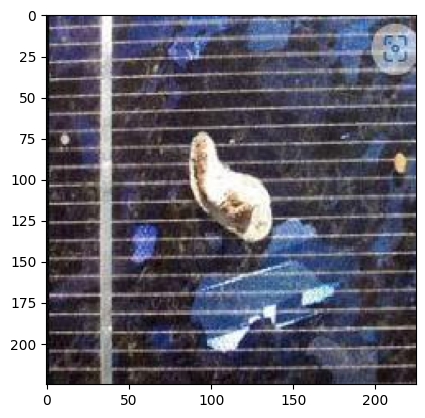

In [21]:
##pics bird 37,55,59,  --> macro pic on brid drop --> predicting wrong class
# pic 65
img_physical = load_img(f"raw_data/training-data/bird/Bird (37).jpeg", target_size=(225, 225))
#predictImage_multiclass(img_physical,model_multi)
plt.imshow(img_physical);

In [ ]:
img_physical = load_img(f"raw_data/training-data/bird/Bird (5).jpeg", target_size=(225, 225))
predictImage_multiclass(img_physical,model_multi)
plt.imshow(img_physical);

In [ ]:
img_physical = load_img(f"raw_data/training-data/dust/Dust (37).jpeg", target_size=(225, 225))
predictImage_multiclass(img_physical,model_multi)
plt.imshow(img_physical);